# Time Series Analysis

### Content:
- Sourcing Time Series Data
- Wrangling/Subsetting
- Cleaning
- Time Series Analysis
- Test for Stationarity
- Check for Autocorrelations

In [3]:
#import libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings

#disable deprecation warnings
warnings.filterwarnings('ignore')

#styling option for plots
plt.style.use('fivethirtyeight')

### Sourcing Time Series Data

In [4]:
#configure API key
quandl.ApiConfig.api_key = '7LscxsFxQxC8ESTtresh'

In [5]:
#import Energy Production and Consumption data --> Crude Oil Prices from 1861
data = quandl.get('BP/CRUDE_OIL_PRICES')

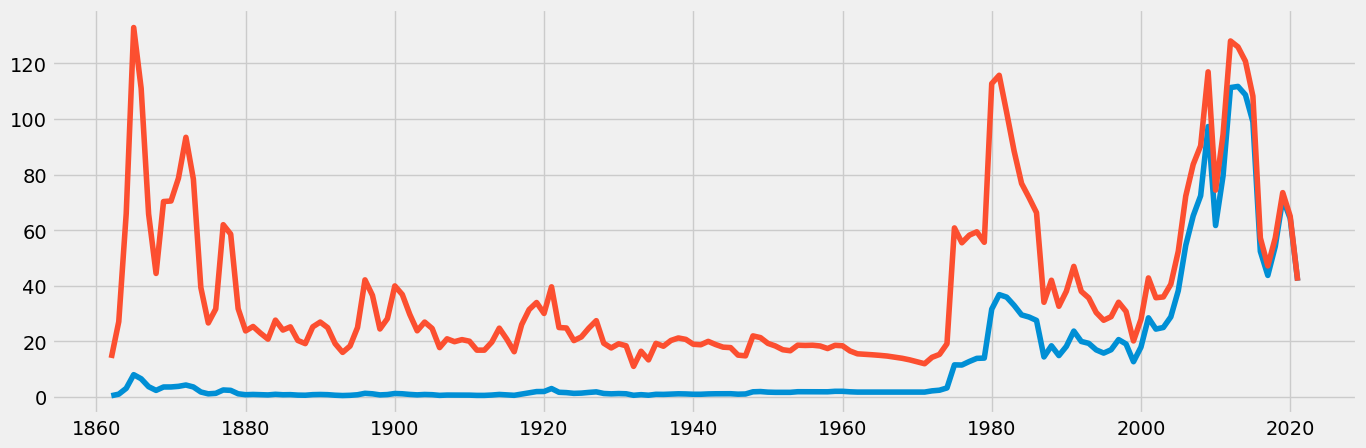

In [7]:
#create a line chart of your data
plt.figure(figsize = (15,5), dpi=100)
plt.plot(data)

- Red line: Price/Barrel in 2020 Dollars (adjusted for inflation)
- Blue Line: Price/Barrel in Contemporary Dollars



### Wrangling/Subsetting

In [10]:
#create a subset of the data dating back only to 1990
data_2 = data.reset_index()

In [13]:
data_2.head()

,Date,Price in Contemporary Dollars,Price in 2020 Dollars
0,1861-12-31,0.49,14.057327
1,1862-12-31,1.05,27.110560
2,1863-12-31,3.15,65.944605
3,1864-12-31,8.06,132.833502
4,1865-12-31,6.59,110.968067


In [14]:
data_2['Date'].value_counts()

1861-12-31    1
1862-12-31    1
1963-12-31    1
1964-12-31    1
1965-12-31    1
             ..
1915-12-31    1
1916-12-31    1
1917-12-31    1
1918-12-31    1
2020-12-31    1
Name: Date, Length: 160, dtype: int64

This is annual data collected on the last day of the year.

In [21]:
data_sub = data_2.loc[data_2['Date'] >= '1990-12-31']

In [22]:
data_sub.shape

(31, 3)

In [23]:
data_sub.head()

,Date,Price in Contemporary Dollars,Price in 2020 Dollars
129,1990-12-31,23.725820,46.981662
130,1991-12-31,20.000914,38.006290
131,1992-12-31,19.320837,35.641091
132,1993-12-31,16.971634,30.397548
133,1994-12-31,15.817626,27.623318


In [24]:
from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date'])
data_sub = data_sub.set_index('datetime')
data_sub = data_sub.drop(columns = ['Date'])
data_sub.head()

,Price in Contemporary Dollars,Price in 2020 Dollars
datetime,,
1990-12-31,23.725820,46.981662
1991-12-31,20.000914,38.006290
1992-12-31,19.320837,35.641091
1993-12-31,16.971634,30.397548
1994-12-31,15.817626,27.623318


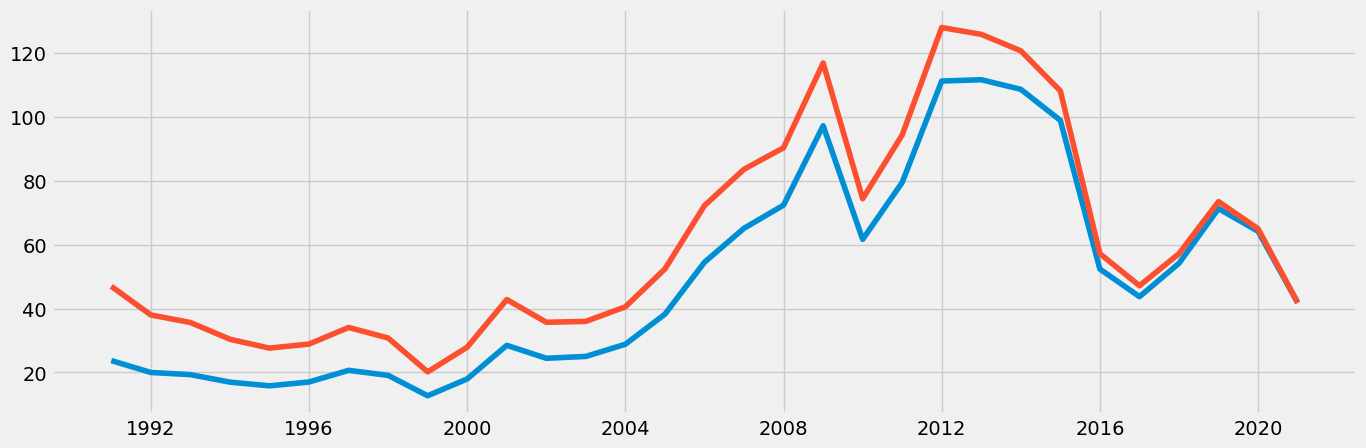

In [25]:
#plot the subset
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

I wanted to leave out the oil prices from the 70's and 80's, which was famous for when OPEC stopped selling oil to the U.S. and lead to alarming inflation. It's an event from history that's not relevant to our analysis and would bias our results.

### Data Cleaning

In [26]:
#check for missing values
data_sub.isnull().sum() 

Price in Contemporary Dollars    0
Price in 2020 Dollars            0
dtype: int64

In [27]:
#check for duplicates
dups = data_sub.duplicated()
dups.sum()

0

### Time Series Analysis

In [35]:
#decomposition for 2020 dollars
decomposition = sm.tsa.seasonal_decompose(data_sub['Price in 2020 Dollars'], model='additive')

In [32]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

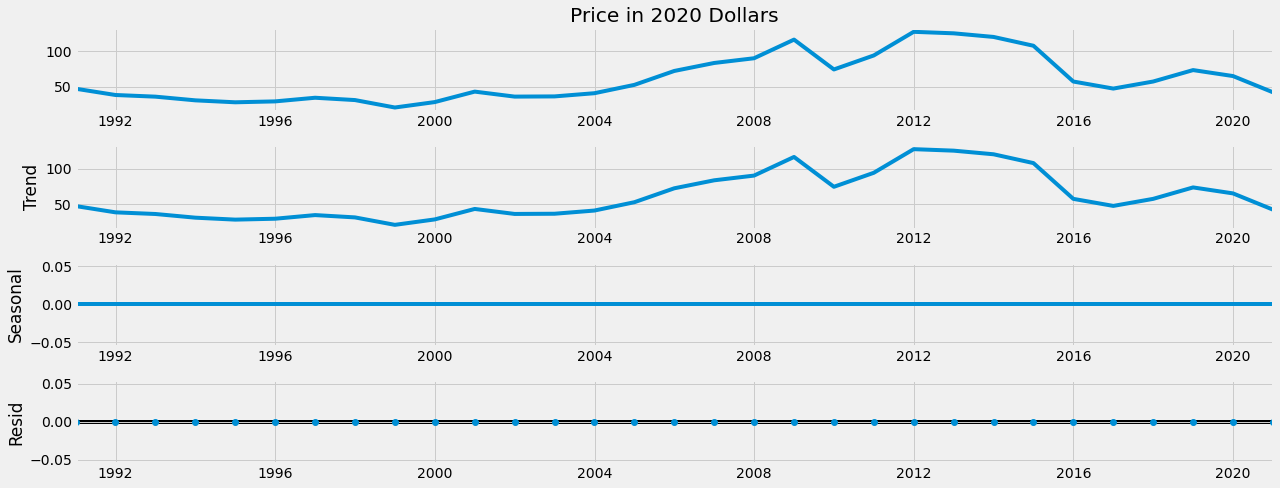

In [38]:
decomposition.plot()
plt.show()

We don't have any seasonality or noise in our data, just a general trend. There are two cycles, one in which it trends upward until 2012, and then another cycle after 2012 in which it begins to trend downward.

### Test for Stationarity

In [39]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries): 
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

dickey_fuller(data_sub['Price in 2020 Dollars'])

Dickey-Fuller Stationarity test:
Test Statistic                 -3.876842
p-value                         0.002212
Number of Lags Used             8.000000
Number of Observations Used    22.000000
Critical Value (1%)            -3.769733
Critical Value (5%)            -3.005426
Critical Value (10%)           -2.642501
dtype: float64


Our test statistic is lower than the critical value for the 1% significance level, meaning that the probability of a unit root being present in our data is less than 1%. Our data is stationary.

### Check for Autocorrelations

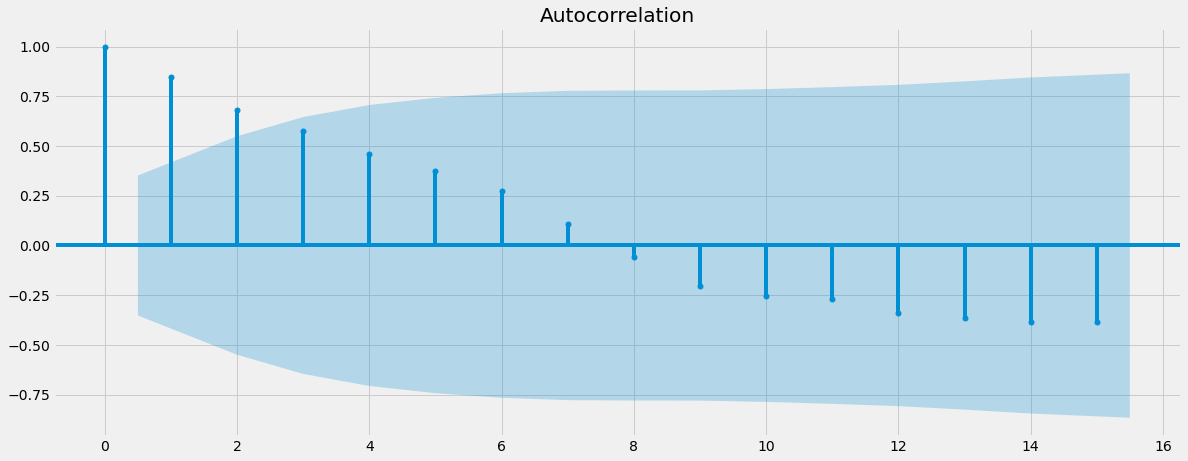

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_sub['Price in 2020 Dollars'])
plt.show()

Most of our data is not autocorrelated. The first three are outside the blue area/ are significantly correlated, but there's little value gained from differencing these out. We can stick with what we have.